In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_printoptions(sci_mode=False, precision=4)

%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [4]:
chars = ''.join(sorted(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

In [5]:
block_size = 4  # context length: how many characters to look back

def build_ds(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n = len(words)
n1 = int(n * 0.8)
n2 = int(n * 0.9)

Xtr, Ytr = build_ds(words[:n1])
Xdev, Ydev = build_ds(words[n1:n2])
Xte, Yte = build_ds(words[n2:])


In [35]:
dim = 16
hidden = 128
C = torch.randn((27, dim)) * 0.05
g = torch.Generator().manual_seed(42)

w1 = torch.randn((dim * block_size, hidden), generator=g) * 0.01
b1 = torch.randn((hidden,), generator=g) * 0.01

w2 = torch.randn((hidden, 27), generator=g) * 0.01
b2 = torch.randn((27,), generator=g) * 0

bngain = torch.ones((1, hidden))
bnbias = torch.ones((1, hidden))

# params = [C, w1, b1, w2, b2, w12, b12]
params = [C, w1, b1, w2, b2, bngain, bnbias]
for p in params:
    p.requires_grad = True

losses = []
grads_abs_mean = []
sum([p.nelement() for p in params])

12491

In [ ]:
x = Xtr[:4]
y = Ytr[:4]
emb = C[x]
h = torch.tanh(emb.view(-1, dim * block_size) @ w1 + b1)
logits = h @ w2 + b2
probs = F.softmax(logits)
print(probs)
print(y)

In [41]:
@torch.no_grad()
def eval(x, y):
    emb = C[x]
    h = torch.tanh(emb.view(-1, dim * block_size) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()
    # print(x.shape[1], loss.item())


for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (128,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    emb = C[x]
    hpreact = emb.view(-1, dim * block_size) @ w1 + b1

    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    hpreact.retain_grad()
    print(hpreact.retains_grad)

    h = torch.tanh(hpreact)
    # h = torch.tanh(h @ w12 + b12)
    logits = h @ w2 + b2

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # -prob[torch.arange(4), Y[:4]].log().mean(), F.cross_entropy(logits, Y[:4])

    loss = F.cross_entropy(logits, y)

    for p in params:
        p.grad = None
    loss.backward()
    losses.append(loss.item())

    lr = 0.1
    if i > 100000: lr = 0.01
    if i % 10000 == 0:
        print(f'{i:7d}, test: {eval(Xdev, Ydev):8.5f}, train: {eval(Xtr, Ytr):8.5f}')

    for p in params:
        p.data -= p.grad * 0.1
    break



True
      0, test:  3.29058, train:  3.29064


Linear True tensor([[     0.0001,     -0.0000,      0.0000,  ...,     -0.0000,
              0.0000,      0.0001],
        [     0.0000,     -0.0000,      0.0000,  ...,      0.0001,
              0.0001,     -0.0001],
        [     0.0000,     -0.0001,     -0.0001,  ...,      0.0000,
              0.0000,      0.0001],
        ...,
        [     0.0000,      0.0001,      0.0000,  ...,     -0.0000,
              0.0000,      0.0001],
        [     0.0000,     -0.0001,     -0.0001,  ...,     -0.0000,
              0.0001,      0.0001],
        [     0.0001,     -0.0000,      0.0000,  ...,     -0.0000,
              0.0000,      0.0001]])
Tanh True tensor([[     0.0001,     -0.0000,      0.0000,  ...,     -0.0000,
              0.0000,      0.0001],
        [     0.0000,     -0.0000,      0.0000,  ...,      0.0001,
              0.0001,     -0.0001],
        [     0.0000,     -0.0001,     -0.0001,  ...,      0.0000,
              0.0000,      0.0001],
        ...,
        [     0.0000,   

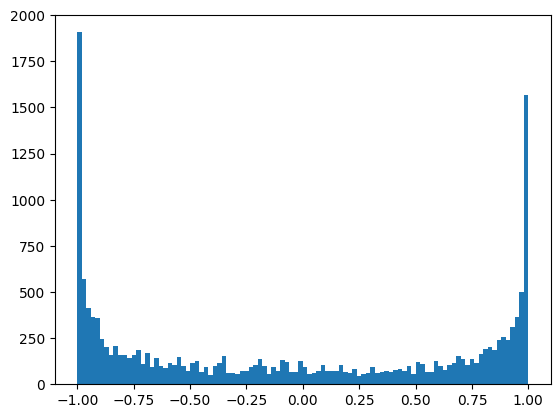

In [124]:
plt.hist(h.view(-1).detach(), 100);

(tensor(4.3984, grad_fn=<StdBackward0>),
 tensor(-0.2593, grad_fn=<MeanBackward0>))

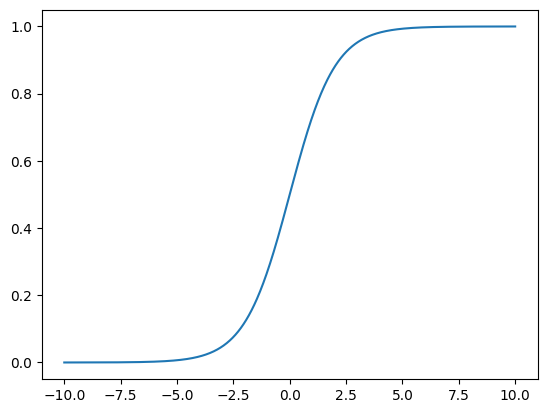

In [146]:
x = torch.linspace(-10, 10, 1000)
plt.plot(x, x.sigmoid()) 
hpreact.std(), hpreact.mean( )

torch.Size([128, 128])

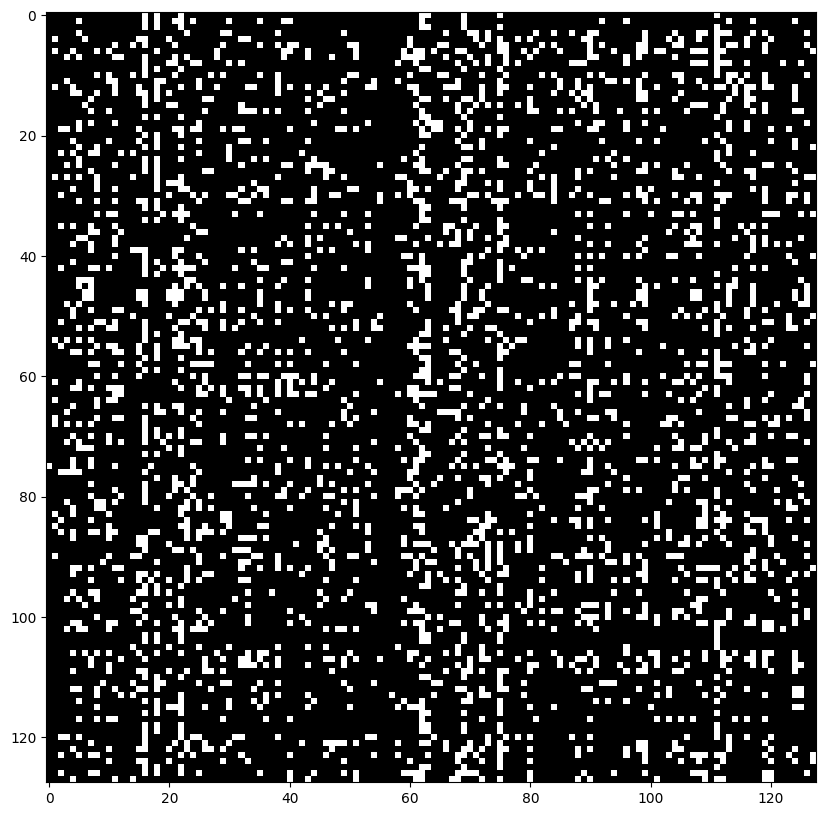

In [122]:
plt.figure(figsize=(10, 10))
plt.imshow(h.abs() > 0.99, cmap='gray')
h.size()

In [22]:
torch.set_printoptions(sci_mode=False, precision=4)

from collections import Counter

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(-1, dim * block_size) @ w1 + b1)
        # h = torch.tanh(h @ w12 + b12)
        logits = h @ w2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, replacement=True).item()
        if ix == 0: break

        out.append(ix)
        context = context[1:] + [ix]
    print(''.join(itos[i] for i in out))

# freqs = Counter(ix.view(-1).tolist())
# plt.figure(figsize=(30, 10))
# x = freqs.keys()
# plt.bar(x, freqs.values())
# plt.xticks(ticks=x)


# plt.hist(ix.view(-1).numpy(), bins=26)

jhistaud
farimisannam
blelie
javiah
avey
tyrianna
zylen
klamiah
zaviyah
erviahia
hannla
lion
land
jataa
braysee
denni
callyrer
jaydan
hanzy
bhanco


tensor(-0.0043) tensor(0.3171)
tensor(-0.0003) tensor(1.0039)


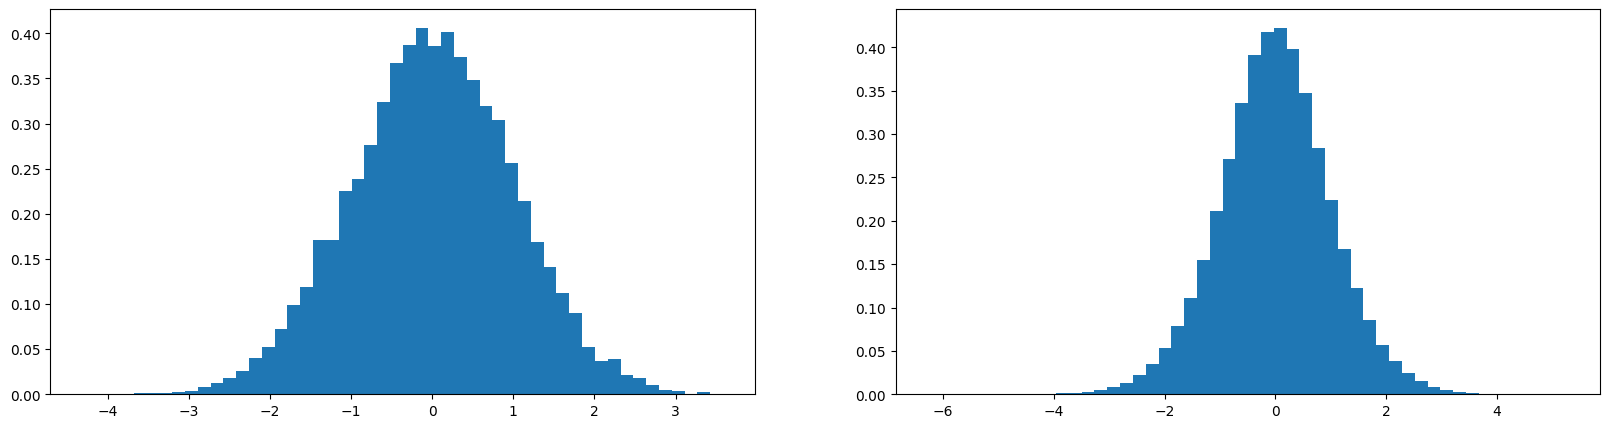

In [33]:
import math
a = torch.randn(1000, 10)
b = torch.randn(10, 300)
torch.nn.init.kaiming_normal_(b, nonlinearity='linear', mode='fan_out')
t = a @ b

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(a.view(-1), bins=50, density=True)
plt.subplot(122)
plt.hist(t.view(-1), bins=50, density=True);

print(b.mean(), b.std())
print(t.mean(), t.std())

Linear True
Tanh True
Linear True
Tanh True
Linear True
Tanh True
Linear True
Tanh True
Linear True
Tanh True
Linear True


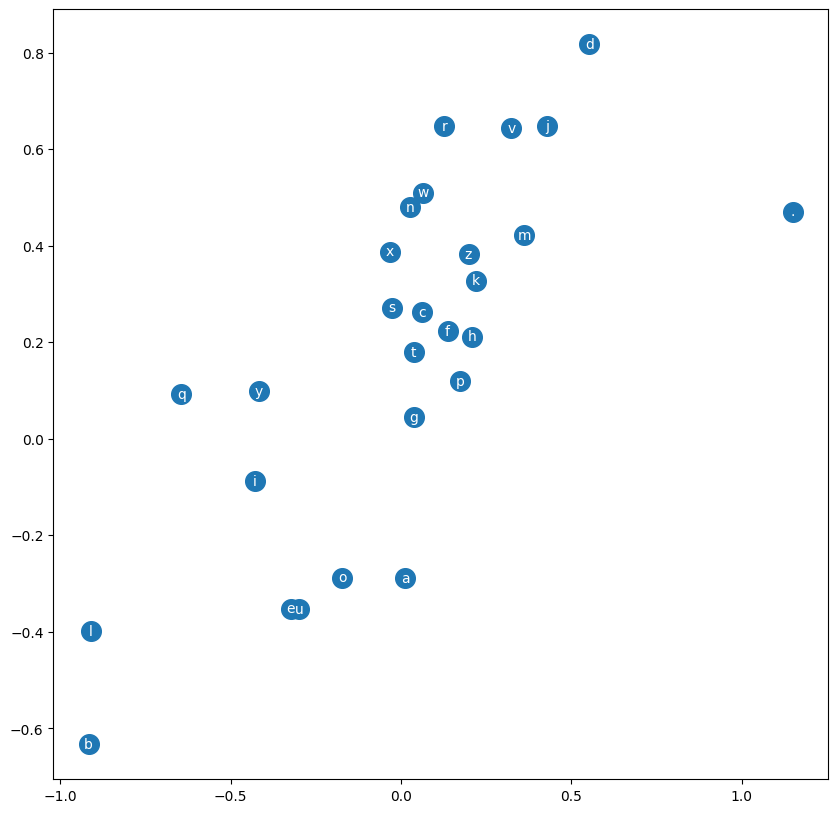

In [516]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:,2].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 2].item(), C[i, 1].item(), itos[i], color='white', ha='center', va='center')


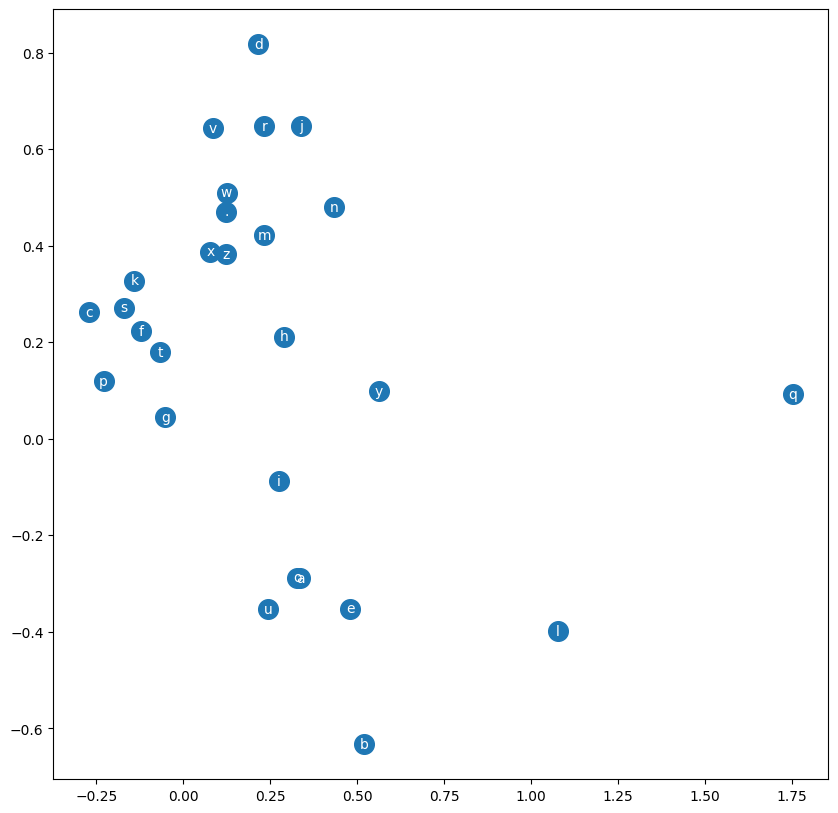

In [515]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], color='white', ha='center', va='center')


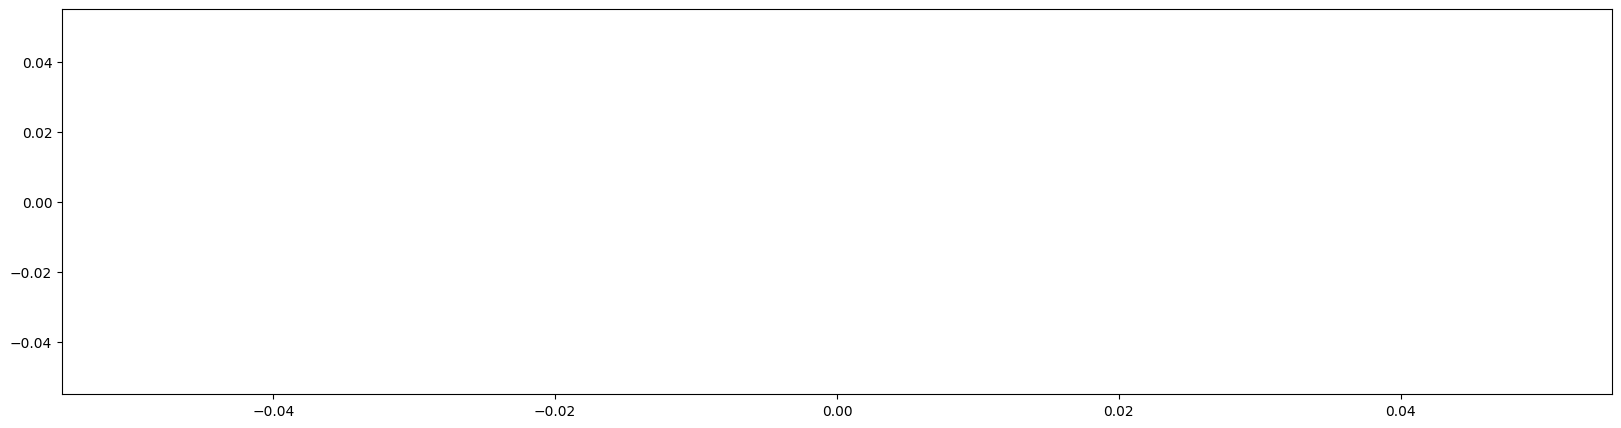

In [533]:
ax = plt.figure(figsize=(20, 5))
plt.plot(grads_abs_mean)

(array([ 12.,   9.,  30.,  31.,  71., 128., 155., 204., 376., 477., 466.,
        259., 191., 102., 102.,  36.,  23.,  18.,   8.,   2.]),
 array([-0.0384731 , -0.0344864 , -0.03049971, -0.02651301, -0.02252632,
        -0.01853962, -0.01455293, -0.01056623, -0.00657954, -0.00259285,
         0.00139385,  0.00538054,  0.00936724,  0.01335393,  0.01734063,
         0.02132732,  0.02531401,  0.02930071,  0.0332874 ,  0.0372741 ,
         0.04126079]),
 <BarContainer object of 20 artists>)

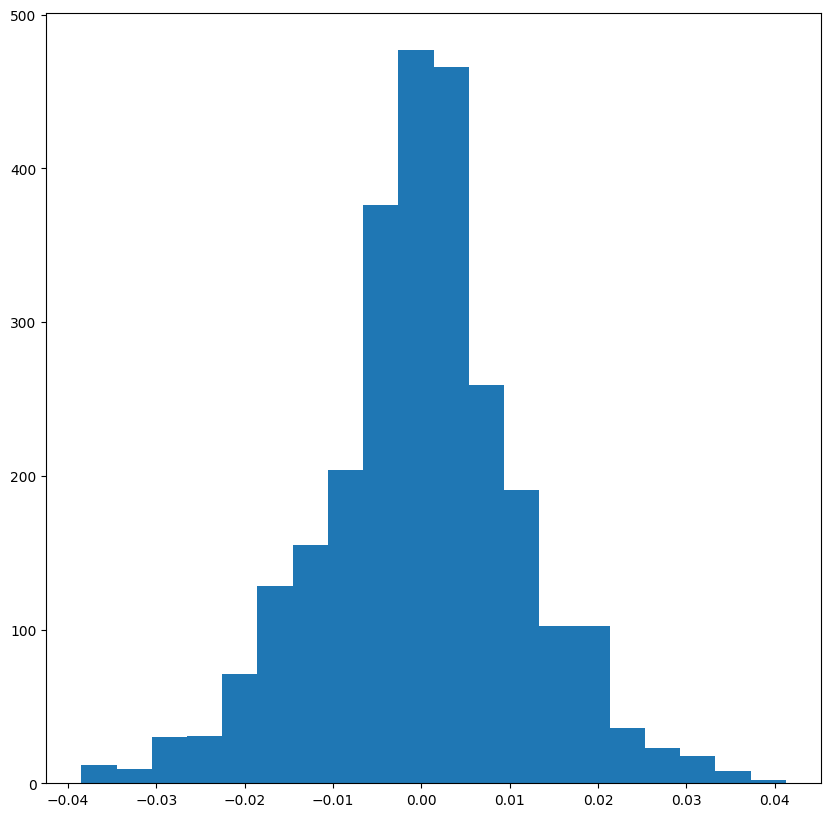

In [525]:
plt.figure(figsize=(10, 10))
plt.hist(w2.grad.view(-1).detach().numpy(), bins=20)


In [337]:
def compress_grads(params):
    all_grads = []
    for p in params:
        all_grads.extend(p.grad.flatten().tolist())

    import struct
    grad_bytes = b''.join(struct.pack('i', int(f * 100000)) for f in all_grads)
    
    # Compress the bytes using zlib
    import zlib
    compressed_grads = zlib.compress(grad_bytes)

    print(len(all_grads), len(compressed_grads), len(grad_bytes))

In [338]:
compress_grads(all_grads)


10187 19983 40748


In [88]:
import numpy

a = numpy.array([1, 2, 3])
t = torch.from_numpy(a)
a[1] = 1
a, t, t.numpy()

x = torch.randn(2, 3, 5)
x, x.permute(2, 0, 1)

(tensor([[[-1.0204, -0.3262, -0.8112, -0.0609,  0.2713],
          [ 0.9692, -0.3279, -2.1037,  0.5561,  0.3346],
          [ 0.2576,  1.9321, -0.9809, -1.4207,  0.9202]],
 
         [[-0.4995, -0.6821,  0.5648, -0.1015, -1.1464],
          [-0.7195, -0.3031, -0.3871, -0.2781,  0.3773],
          [ 0.7610,  0.2097, -0.8640, -1.1704, -0.6160]]]),
 tensor([[[-1.0204,  0.9692,  0.2576],
          [-0.4995, -0.7195,  0.7610]],
 
         [[-0.3262, -0.3279,  1.9321],
          [-0.6821, -0.3031,  0.2097]],
 
         [[-0.8112, -2.1037, -0.9809],
          [ 0.5648, -0.3871, -0.8640]],
 
         [[-0.0609,  0.5561, -1.4207],
          [-0.1015, -0.2781, -1.1704]],
 
         [[ 0.2713,  0.3346,  0.9202],
          [-1.1464,  0.3773, -0.6160]]]))

In [113]:
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
loss = F.binary_cross_entropy(torch.sigmoid(input), target)
# loss.backward()

In [127]:
numpy.log(1/27)

np.float64(-3.295836866004329)

In [186]:
class  Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


In [187]:
n_embd = 16
n_hidden = 128
batch_size = 128
C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for l in layers for p in l.parameters()]
for p in parameters: p.requires_grad = True
print(sum(p.numel() for p in parameters))


def call_model(x, y=None):
    emb = C[x] # (bach_size, block_size, n_emb)
    x = emb.view(emb.shape[0], -1)
    for l in layers:
        x = l(x)
    
    if y is None: return x
    return F.cross_entropy(x, y)

78283


In [188]:
ud = []
import torch.optim


for i in range(100000):
    ix = torch.randint(0, Xtr.shape[0], (128, ))
    xb = Xtr[ix]
    yb = Ytr[ix]
    loss = call_model(xb, yb)
    
    for l in layers: l.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10000 else 0.03
    for p in parameters:
        p.data -= lr * p.grad
    
    # if i % 2500 == 0:
        # print(f'{i:7d}, {loss.item():8.5f}, test: {call_model(Xdev, Ydev).item():8.5f}, train: {call_model(Xtr, Ytr).item():8.5f}')
        # print(loss.item(), i)
    # if i > 10: break
    ud.append([(lr * p.grad.std() / p.std()).log10().item() for p in parameters])
    if i > 20000: break
    # break

tanh 1. mean -0.00000, std 0.00099, mean_abs: 0.00072, staturated: 0.00%
tanh 3. mean -0.00000, std 0.00072, mean_abs: 0.00053, staturated: 0.00%
tanh 5. mean -0.00000, std 0.00055, mean_abs: 0.00040, staturated: 0.00%
tanh 7. mean +0.00000, std 0.00040, mean_abs: 0.00029, staturated: 0.00%
tanh 9. mean -0.00000, std 0.00027, mean_abs: 0.00020, staturated: 0.00%


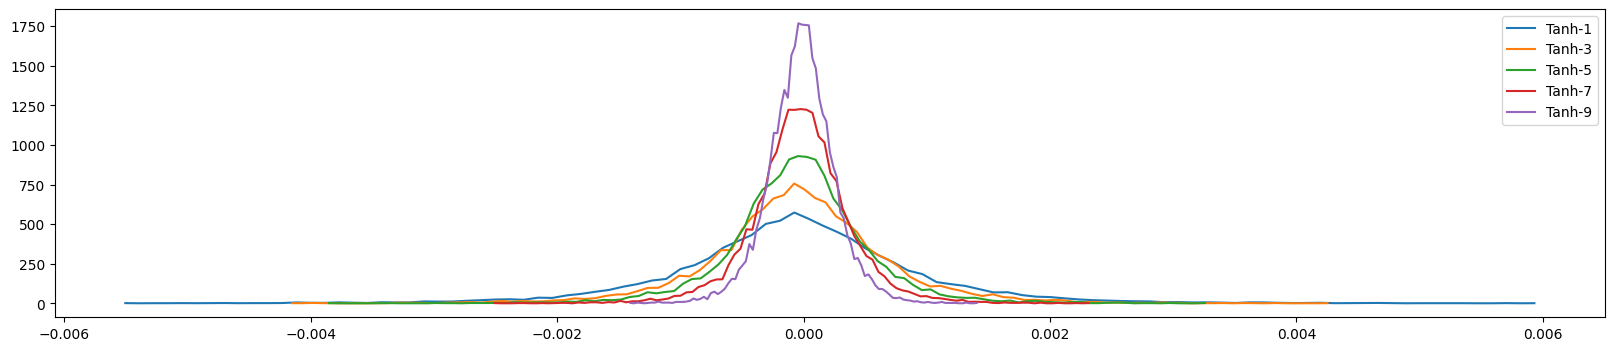

In [101]:
plt.figure(figsize=(20, 4))
lengends = []
for idx, l in enumerate(layers[:-1]):
    if isinstance(l, Tanh):
        t = l.out.grad
        print('tanh %d. mean %+.5f, std %7.5f, mean_abs: %.5f, staturated: %4.2f%%' % 
              (idx, t.mean(), t.std(), t.abs().mean(), (t > 0.97).float().mean() * 100.0))

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx.detach()[:-1], hy.detach())
        lengends.append('Tanh-%d' % idx)
plt.legend(lengends);


tanh 1. mean +0.00000, std 0.00002, mean_abs: 0.00001, staturated: 0.00%
tanh 3. mean -0.00000, std 0.00003, mean_abs: 0.00002, staturated: 0.00%
tanh 5. mean +0.00000, std 0.00005, mean_abs: 0.00003, staturated: 0.00%
tanh 7. mean -0.00000, std 0.00008, mean_abs: 0.00005, staturated: 0.00%
tanh 9. mean +0.00000, std 0.00012, mean_abs: 0.00009, staturated: 0.00%


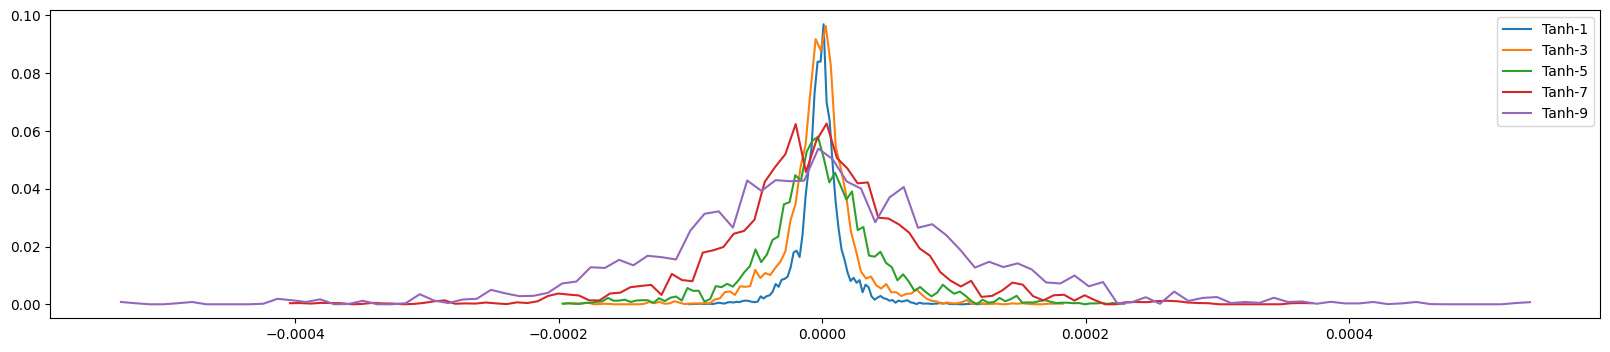

In [139]:
plt.figure(figsize=(20, 4))
lengends = []
for idx, l in enumerate(layers[:-1]):
    if isinstance(l, Tanh):
        t = l.out.grad
        print('tanh %d. mean %+.5f, std %7.5f, mean_abs: %.5f, staturated: %4.2f%%' % 
              (idx, t.mean(), t.std(), t.abs().mean(), (t > 0.97).float().mean() * 100.0))

        hy, hx = torch.histogram(t, density=True)
        hy = hy / hy.sum()
        plt.plot(hx.detach()[:-1], hy.detach())
        lengends.append('Tanh-%d' % idx)
plt.legend(lengends);

In [135]:
t = torch.randn((100, 100))
hy, hx = torch.histogram(t, density=True)
hy = hy / hy.sum()
hy.sum()
# plt.hist(t.view(-1), density=True)



tensor(1.)

In [164]:
for p in parameters:
    if p.dim() != 2: continue

    print(f'shape: {p.shape}, std: {p.std():+.5f}, p_std: {p.grad.std():+.5f}, ratio %.5f' % (p.std() / p.grad.std()))
    # print(p.shape, p.dim())
    # print(p)

shape: torch.Size([27, 16]), std: +1.05441, p_std: +0.00847, ratio 124.54529
shape: torch.Size([64, 128]), std: +0.22654, p_std: +0.00732, ratio 30.94343
shape: torch.Size([128, 128]), std: +0.16234, p_std: +0.00549, ratio 29.55422
shape: torch.Size([128, 128]), std: +0.16213, p_std: +0.00527, ratio 30.76309
shape: torch.Size([128, 128]), std: +0.16133, p_std: +0.00481, ratio 33.51358
shape: torch.Size([128, 128]), std: +0.15929, p_std: +0.00423, ratio 37.63549
shape: torch.Size([128, 27]), std: +0.13137, p_std: +0.01145, ratio 11.47601


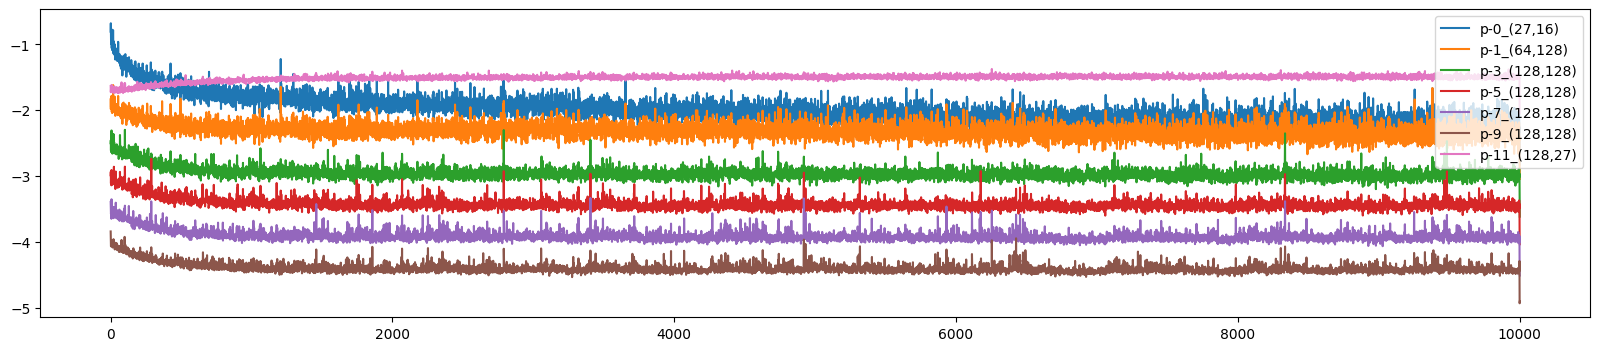

In [179]:
plt.figure(figsize=(20, 4))
lengends = []
for idx, l in enumerate(parameters):
    if l.dim() != 2: continue
    plt.plot([ud[i][idx] for i in range(len(ud))])
    d1, d2 = l.shape
    lengends.append('p-%d_(%d,%d)' % (idx, d1, d2))
plt.legend(lengends);

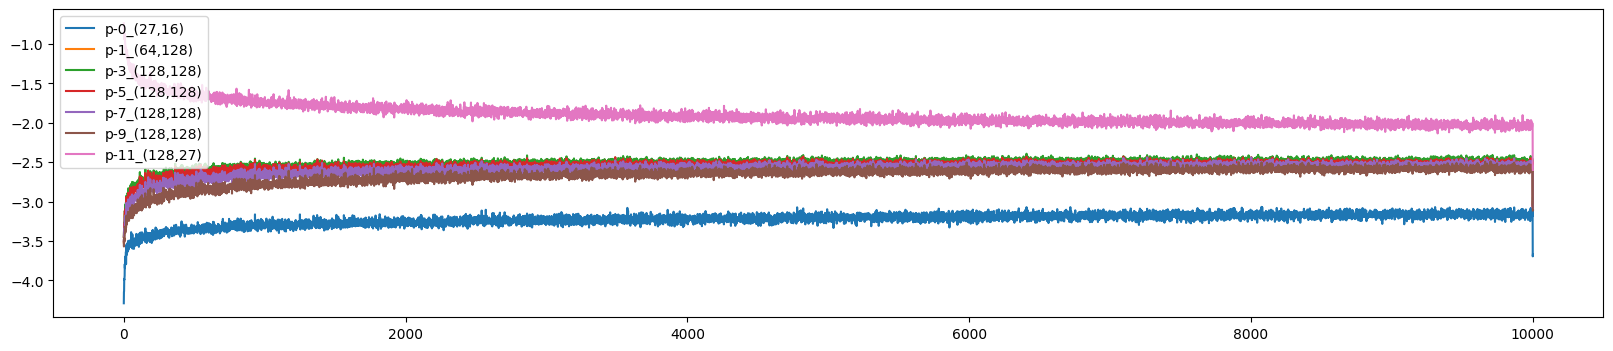

In [185]:
plt.figure(figsize=(20, 4))
lengends = []
for idx, l in enumerate(parameters):
    if l.dim() != 2: continue
    plt.plot([ud[i][idx] for i in range(len(ud))])
    d1, d2 = l.shape
    lengends.append('p-%d_(%d,%d)' % (idx, d1, d2))
plt.legend(lengends);